[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/exercises/8_ex_ensemble_learning.ipynb) 

# BADS Exercise 8 on ensemble learning
This exercise revisits some of the concepts covered in [Tutorial 8 on ensemble learning](https://github.com/Humboldt-WI/bads/blob/master/tutorials/8_nb_ensemble_learning.ipynb). We will take a close look at bagging and analyze its impact on the predictive accuracy, and implement one of the boosting algorithms, Adaboost.

## Loading the data 
Fo this tutorial, we will use HMEQ credit risk data available at [our GitHub repo](https://github.com/Humboldt-WI/bads/blob/master/data/hmeq_prepared.csv). By now, you have imported different data sets multiple times in previous tutorials, but this step is always necessary when working with data. Your preliminary task is to load the HMEQ data set into a `pandas DataFrame`.

In [4]:
# Import libraries
import pandas as pd
import numpy as np

# Load the data from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df       = pd.read_csv(data_url, index_col = 'index')

# encode target variable
df['BAD'] = df['BAD'].astype(int) 

# create variables X and y for subsequent parts
y = df.pop('BAD')
X = df

Now we can proceed to the tasks on ensemble learning!

## Tasks

### Task 1

Ensemble learning works by reducing bias and/or variance. We begin with examining the variance component. 

In the first task, you will write code that trains and tests a classifier multiple times on different subsets of HMEQ data and examines the classifier preformance. We prepared two versions of this task: *simple* and *for the experts*. Read the task description below and proceed with the version you feel ready to tackle!

*Simple version:* set up a loop to sample the data, calling the sklearn function `train_test_split()` multiple times in a loop. You can use either logistic regression or a decision tree as a classifier. Train and test a new classifier on the sampled data in each iteration of the loop and compute its AUC on the test set. Run your code for 100 iterations and visualize the variation in AUC performance by means of a boxplot. Briefly discuss your findings.

In [2]:
X.shape

(5960, 18)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

n = 100  # number of iterations
test_frac = 0.3  # Percentage of test set cases


model = DecisionTreeClassifier(max_depth=5)
model_performance = []
for i in np.arange(n):
    
    # Partion the data
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=test_frac)
    
    # Train the model
    model.fit(X_tr, y_tr)
    
    
    # Apply model to test set
    y_hat = model.predict_proba(X_ts)[:, 1]
    
    # Get model performance
    auc = roc_auc_score(y_ts, y_hat)
    
    # Store results
    model_performance.append(auc)
    

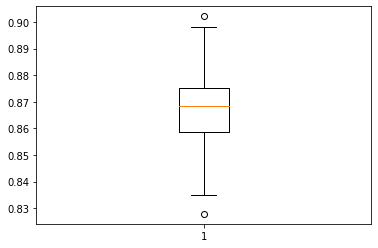

In [6]:
## Chart performance estimates
import matplotlib.pyplot as plt

plt.boxplot(model_performance)
plt.show()


*For the experts:* perform the same task as above but wrap your code in a function `examine_variance()` that:
- supports both logit and decision tree as a classifier
- allows to specify the number of iterations and test sample size
- facilitates controlled sampling of the data such that you randomize either the training or the test set or both sets in each iteration. The idea is that your code should let you study the isolated effect of randomizing only the training data while always predicting the same test data, or the isolated effect of applying the same model to multiple randomized test sets, or the overall effect of sampling the data just as in the simple version
- returns a list of AUC values from each iteration

Run your function for 100 iterations and visualize the AUC values using a boxplot. Briefly discuss differences between the AUC variance when randomizing the training data, the test data or both. 

In [4]:
def bootstrap(X, y, bts_size=None, seed=1):
    ''' Draw a bootstrap sample of the data (i.e., X and y) and return '''
    
    
    if bts_size == None:
        bts_size = X.shape[0]
    
    np.random.seed(seed)
        
    # Draw a sample of random int values that we can use to index our data
    idx = np.random.randint(low=0, high=X.shape[0], size=bts_size)
    
    X_bts = X.iloc[idx]
    y_bts = y.iloc[idx]
    
    return (X_bts, y_bts)

In [5]:
def examine_variance(model, X, y, n_iter=100, test_frac=0.3, rnd_train=True, rnd_test=True):
    
    model_performance = []
    
    # Partion the data
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=test_frac, random_state=8)

    for i in np.arange(n):
    
        # Check if we need to bootstrap the training set
        if rnd_train==True:
            X_tr_bts, y_tr_bts = bootstrap(X_tr, y_tr, seed=i)
        else:
            X_tr_bts = X_tr.copy()
            y_tr_bts = y_tr.copy()
    
        # Train the model
        model.fit(X_tr_bts, y_tr_bts)

        # Check if we need to bootstrap the test set    
        if rnd_test==True:
            X_ts_bts, y_ts_bts = bootstrap(X_ts, y_ts, seed=i)
        else:
            X_ts_bts = X_ts.copy()
            y_ts_bts = y_ts.copy()

        # Apply model to test set
        y_hat = model.predict_proba(X_ts_bts)[:, 1]

        # Get model performance
        auc = roc_auc_score(y_ts_bts, y_hat)

        # Store results
        model_performance.append(auc)
    
    
    return model_performance
    

In [6]:
tree = DecisionTreeClassifier(max_depth=5)
logit = LogisticRegression()

# Randomize the test set
auc_tree_ts = examine_variance(tree, X, y, rnd_train=False, rnd_test=True)
auc_logit_ts = examine_variance(logit, X, y, rnd_train=False, rnd_test=True)

# Randomize the training set
auc_tree_tr = examine_variance(tree, X, y, rnd_train=True, rnd_test=False)
auc_logit_tr = examine_variance(logit, X, y, rnd_train=True, rnd_test=False)

#Randomize bot sets
auc_tree_both = examine_variance(tree, X, y, rnd_train=True, rnd_test=True)
auc_logit_both = examine_variance(logit, X, y, rnd_train=True, rnd_test=True)

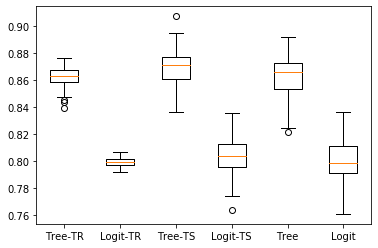

In [7]:
plt.boxplot([auc_tree_tr, auc_logit_tr, auc_tree_ts, auc_logit_ts, auc_tree_both, auc_logit_both])
plt.xticks(ticks=[1, 2, 3, 4, 5, 6], labels=['Tree-TR', 'Logit-TR', 'Tree-TS', 'Logit-TS', 'Tree', 'Logit'])
plt.show()

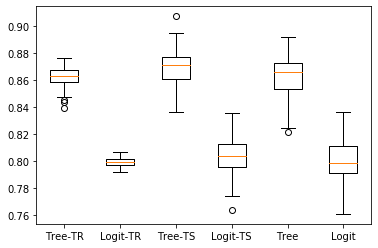

In [8]:
plt.boxplot([auc_tree_tr, auc_logit_tr, auc_tree_ts, auc_logit_ts, auc_tree_both, auc_logit_both])
plt.xticks(ticks=[1, 2, 3, 4, 5, 6], labels=['Tree-TR', 'Logit-TR', 'Tree-TS', 'Logit-TS', 'Tree', 'Logit'])
plt.show()

### Task 2

Implement a bagged logistic regression classifier from scratch. You can use the `sklearn` class `LogisticRegressionClassifier` for implementing the base model. The actual bagging step, however, should be implemented from scratch

In [9]:
def bagging(bag_X, bag_y, test_data, useLogit=True, bagging_steps=100, bag_seed=888):
    
    ensemble = []
    for i in np.arange(bagging_steps):
        # bootstrap sampling
        Xtr, ytr = bootstrap(bag_X, bag_y, seed=i+bag_seed)
    
        # check a classifier is available
        if useLogit==True:
            classifier = LogisticRegression()
        else:
            classifier = DecisionTreeClassifier()
    
        # fit model to data    
        classifier.fit(Xtr, ytr)
    
        # add classifier to ensemble
        ensemble.append(classifier)
    
    # predict test data if any
    yhat = []
    #yhat_ensemble = 0
    #if test_data != None:
    for model in ensemble:
        yhat.append( model.predict_proba(test_data)[:,1] )
    
    yhat_ensemble = np.mean(yhat, axis=0)

    return ensemble, yhat_ensemble, yhat

### Task 3

Theory predicts that bagging should work better for unstable base models like trees than for stable base models like logistic regression. Use the custom bagging algorithm developed in Task 2 to verify this assertion for the HMEQ loan dataset. Specifically:
  - chose a proper experimental design to compare models (split-sample or cross-validation)
  - train two simple classifiers: 
    - logistic regression
    - decision tree
  - train two bagging classifiers:
      - bagged logistic regression
      - bagged decision tree
  - both bagging classifiers should use your custom bagging function from Task 2
  - compare the predictive performance of the bagging ensembles on the test data and briefly discuss your findings

In [10]:
# partition the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

# create bagged logistic regression
bagged_logit, yhat, yhat_all = bagging(Xtrain, ytrain, Xtest, useLogit=True, bagging_steps=10)

# create bagged tree classifier
bagged_tree, yhat_tree, _ = bagging(Xtrain, ytrain, Xtest, useLogit=False, bagging_steps=10)

# Single model versions of logit & tree
logit = LogisticRegression()
logit.fit(Xtrain, ytrain)

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(Xtrain, ytrain)

print("AUC of logit is: ", roc_auc_score(ytest, logit.predict_proba(Xtest)[:,1]))
print("AUC of bagged logit is: ", roc_auc_score(ytest, yhat))

print("AUC of tree is: ", roc_auc_score(ytest, tree.predict_proba(Xtest)[:,1]))
print("AUC of bagged Tree is: ", roc_auc_score(ytest, yhat_tree))


AUC of logit is:  0.8157368502956739
AUC of bagged logit is:  0.814828431372549
AUC of tree is:  0.8778225178960474
AUC of bagged Tree is:  0.9311284235916588


In [10]:
# Partition the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

# Single model versions of logit & tree
logit = LogisticRegression()
logit.fit(Xtrain, ytrain)

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(Xtrain, ytrain)

# Bagged logit
blogit = Bagged_learner(base_learner=logit, bagging_steps=100, bag_seed=888)
blogit.fit(Xtrain, ytrain)

# Bagged logit
btree = Bagged_learner(base_learner=tree, bagging_steps=100, bag_seed=888)
btree.fit(Xtrain, ytrain)

print("AUC of logit is: ", roc_auc_score(ytest, logit.predict_proba(Xtest)[:,1]))
# prediction of bagged logit
yhat_blogit, _ = blogit.predict_proba(Xtest)
print("AUC of bagged logit is: ", roc_auc_score(ytest, yhat_blogit))

#prediction of bagged tree
yhat_tree, _ = btree.predict_proba(Xtest)
print("AUC of tree is: ", roc_auc_score(ytest, tree.predict_proba(Xtest)[:,1]))
print("AUC of bagged Tree is: ", roc_auc_score(ytest, yhat_tree))

AUC of logit is:  0.7834756425677387
AUC of bagged logit is:  0.7836517156242087
AUC of tree is:  0.8548129273233729
AUC of bagged Tree is:  0.8860728190681186


In [7]:
class Bagged_learner:
    
    def __init__(self, base_learner, bagging_steps=100, bag_seed=888):
        """ Constructor:
            Receives configuration information and stores it in objects of the class.
        """
        self.steps = bagging_steps
        self.base_learner = base_learner
        self.seed = bag_seed
        self.ensemble = []  # list with trained base models
            
    
    def bootstrap(self, X, y, sample_size=0, bag_seed=888):
        """
        Draw bootstrap sample of the data
        """    
        if sample_size == 0:
            sample_size = X.shape[0]
    
        np.random.seed(bag_seed)
        # Draw a sample of random int values that we can use to index our data
        idx = np.random.randint(low=0, high=X.shape[0], size=sample_size)
    
        X_bts = X.iloc[idx]
        y_bts = y.iloc[idx]
    
        return (X_bts, y_bts)
    
    def fit(self, X, y):
        """
        Training step:
        Train base learner multiple times and add to internal list representing the ensemble
        """
        
        # Bagging loop training one base model per iteration
        for i in np.arange(self.steps):
            # draw bootstrap sample
            Xtr, ytr = self.bootstrap(X, y, bag_seed=i+self.seed)
            
            # fit model to that sample
            model = sklearn.base.clone(self.base_learner)
            model.fit(Xtr, ytr)
    
            # add classifier to ensemble
            self.ensemble.append(model)
        
        
    def predict_proba(self, X):    
        """ Predict test data"""
        
        # call every base model and collect test set predictions
        yhat_base = []
        for model in self.ensemble:
            yhat_base.append( model.predict_proba(X)[:,1] )
    
        # create composite forecast as simple average
        yhat_ensemble = np.mean(yhat_base, axis=0)
        
        return yhat_ensemble, yhat_base
    

### Task 4 [optional]

#### 4.1. Further enhance the analysis from Task 3 as follows:
  - repeat the comparison of bagged logit versus bagged trees multiple times with different training and testing data sets
  - depict the results (predictive performance) as a boxplot

In [12]:
n_runs = 25  # number of repetitions of the experiment

# prepare data structure to store the results (i.e., auc per model and run)
auc_logit = []
auc_tree = []
# ... not a good solution

# could use a dic -> good idea
results = {"logit": [], "tree": [], "bag_logit": [], "bag_tree": [] }

# could also use a data frame -> also suitable
dfresults = pd.DataFrame(columns=['logit', 'tree', 'bag_logit', 'bag_tree'])

# Single model versions of logit & tree
logit = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=5)    

for i in np.arange(n_runs):
    # Partition the data
    #--------------------------------------------
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=i)

    # Training step
    #--------------------------------------------
    # Fit single models
    logit.fit(Xtrain, ytrain)
    tree.fit(Xtrain, ytrain)

    # Bagged logit
    blogit = Bagged_learner(base_learner=logit, bagging_steps=100, bag_seed=888)
    blogit.fit(Xtrain, ytrain)

    # Bagged tree
    btree = Bagged_learner(base_learner=tree, bagging_steps=100, bag_seed=888)
    btree.fit(Xtrain, ytrain)

    # Prediction step
    #--------------------------------------------
    yhat_blogit, _ = blogit.predict_proba(Xtest)
    yhat_btree, _ = btree.predict_proba(Xtest)
    
    # Store results
    results["logit"].append( roc_auc_score(ytest, logit.predict_proba(Xtest)[:,1]) )
    results["bag_logit"].append( roc_auc_score(ytest, yhat_blogit) )
    
    results["tree"].append( roc_auc_score(ytest, tree.predict_proba(Xtest)[:,1]) )
    results["bag_tree"].append( roc_auc_score(ytest, yhat_btree) )
    
    # not needed for the task and only for illustration: how to use the data frame
    dfresults.loc[i, 'logit'] = roc_auc_score(ytest, logit.predict_proba(Xtest)[:,1])
    dfresults.loc[i, 'tree']  = roc_auc_score(ytest,  tree.predict_proba(Xtest)[:,1])
    dfresults.loc[i, 'bag_logit'] = roc_auc_score(ytest, yhat_blogit)
    dfresults.loc[i, 'bag_tree']  = roc_auc_score(ytest, yhat_btree)
    


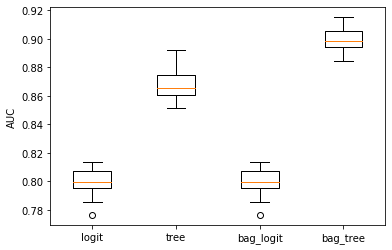

In [17]:
# Visualize results
plt.boxplot(dfresults.values)
plt.ylabel('AUC')
plt.xticks(ticks = [1, 2, 3, 4], labels=dfresults.columns)
plt.show()

### 4.2. Investigate the impact of the ensemble size:
- try out different settings for the hyperparameter *ensemble size* (number of bagging iterations)
- produce a line plot of predictive performance versus ensemble size for bagged logit and bagged tree
- identify the suitable ensemble size for both classifiers  

In [33]:
# data partitioning
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=i)

# max ensemble size 
max_size = 500

# fit one ensemble of maximum size
blogit = Bagged_learner(base_learner=logit, bagging_steps=max_size, bag_seed=888)
blogit.fit(Xtrain, ytrain)

btree = Bagged_learner(base_learner=tree, bagging_steps=max_size, bag_seed=888)
btree.fit(Xtrain, ytrain)

# get prediction
_, yhat_base = blogit.predict_proba(Xtest)
_, yhat_base_tree = btree.predict_proba(Xtest)

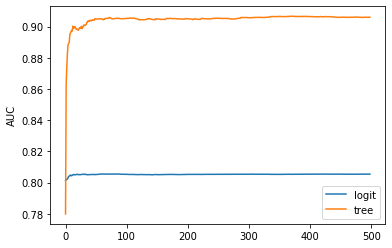

In [34]:
aucs_logit = []  # data structure to collect results
aucs_tree = []
# for loop using different ensemble sizes
for i in np.arange(max_size):
    
    # i is zero in the first iteration
    if i==0:
        continue
    
    # simulate ensemble of size i
    yhat = np.mean(yhat_base[:i], axis=0)
    yhat_tree = np.mean(yhat_base_tree[:i], axis=0)
    
    # store the results
    aucs_logit.append(roc_auc_score(ytest, yhat))
    aucs_tree.append(roc_auc_score(ytest, yhat_tree))
    
# visualize the results
plt.plot(aucs_logit, label='logit')
plt.plot(aucs_tree, label='tree')
plt.ylabel('AUC')
plt.legend(loc='best')
plt.show()

### Task 5
Write a custom Python function that implements the *Adaboost* algorithm. Follow the pseudo-code of the algorithm, as shown in the lecture materials. Design your function such that it accepts a `sklearn` model object as argument and than runs Adaboost using the corresponding base classifier. Test your function on the HMEQ data and evaluate performance in terms of AUC.

# Well done! Your ensembles performed great!